In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 3
2023-07-07 11:46:01.117049


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-0.0006)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-10.0639)
penalty_target_min tensor(-6.1598) penalty_target_max tensor(23.0161)
train_loss:  -5.05618691905588
valid_loss:  -4.854262024688721
h_min_tilde -6.159778 ell_tilde -5.015801940182448 kappa_tilde 0.009349567245804704
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.6636849038988353
valid_loss:  -1.0198550560712814
weight_alpha 1.0 h_min_tilde -6.159778 ell_tilde -0.7349189343333244 kappa_tilde 0.004293443630022839


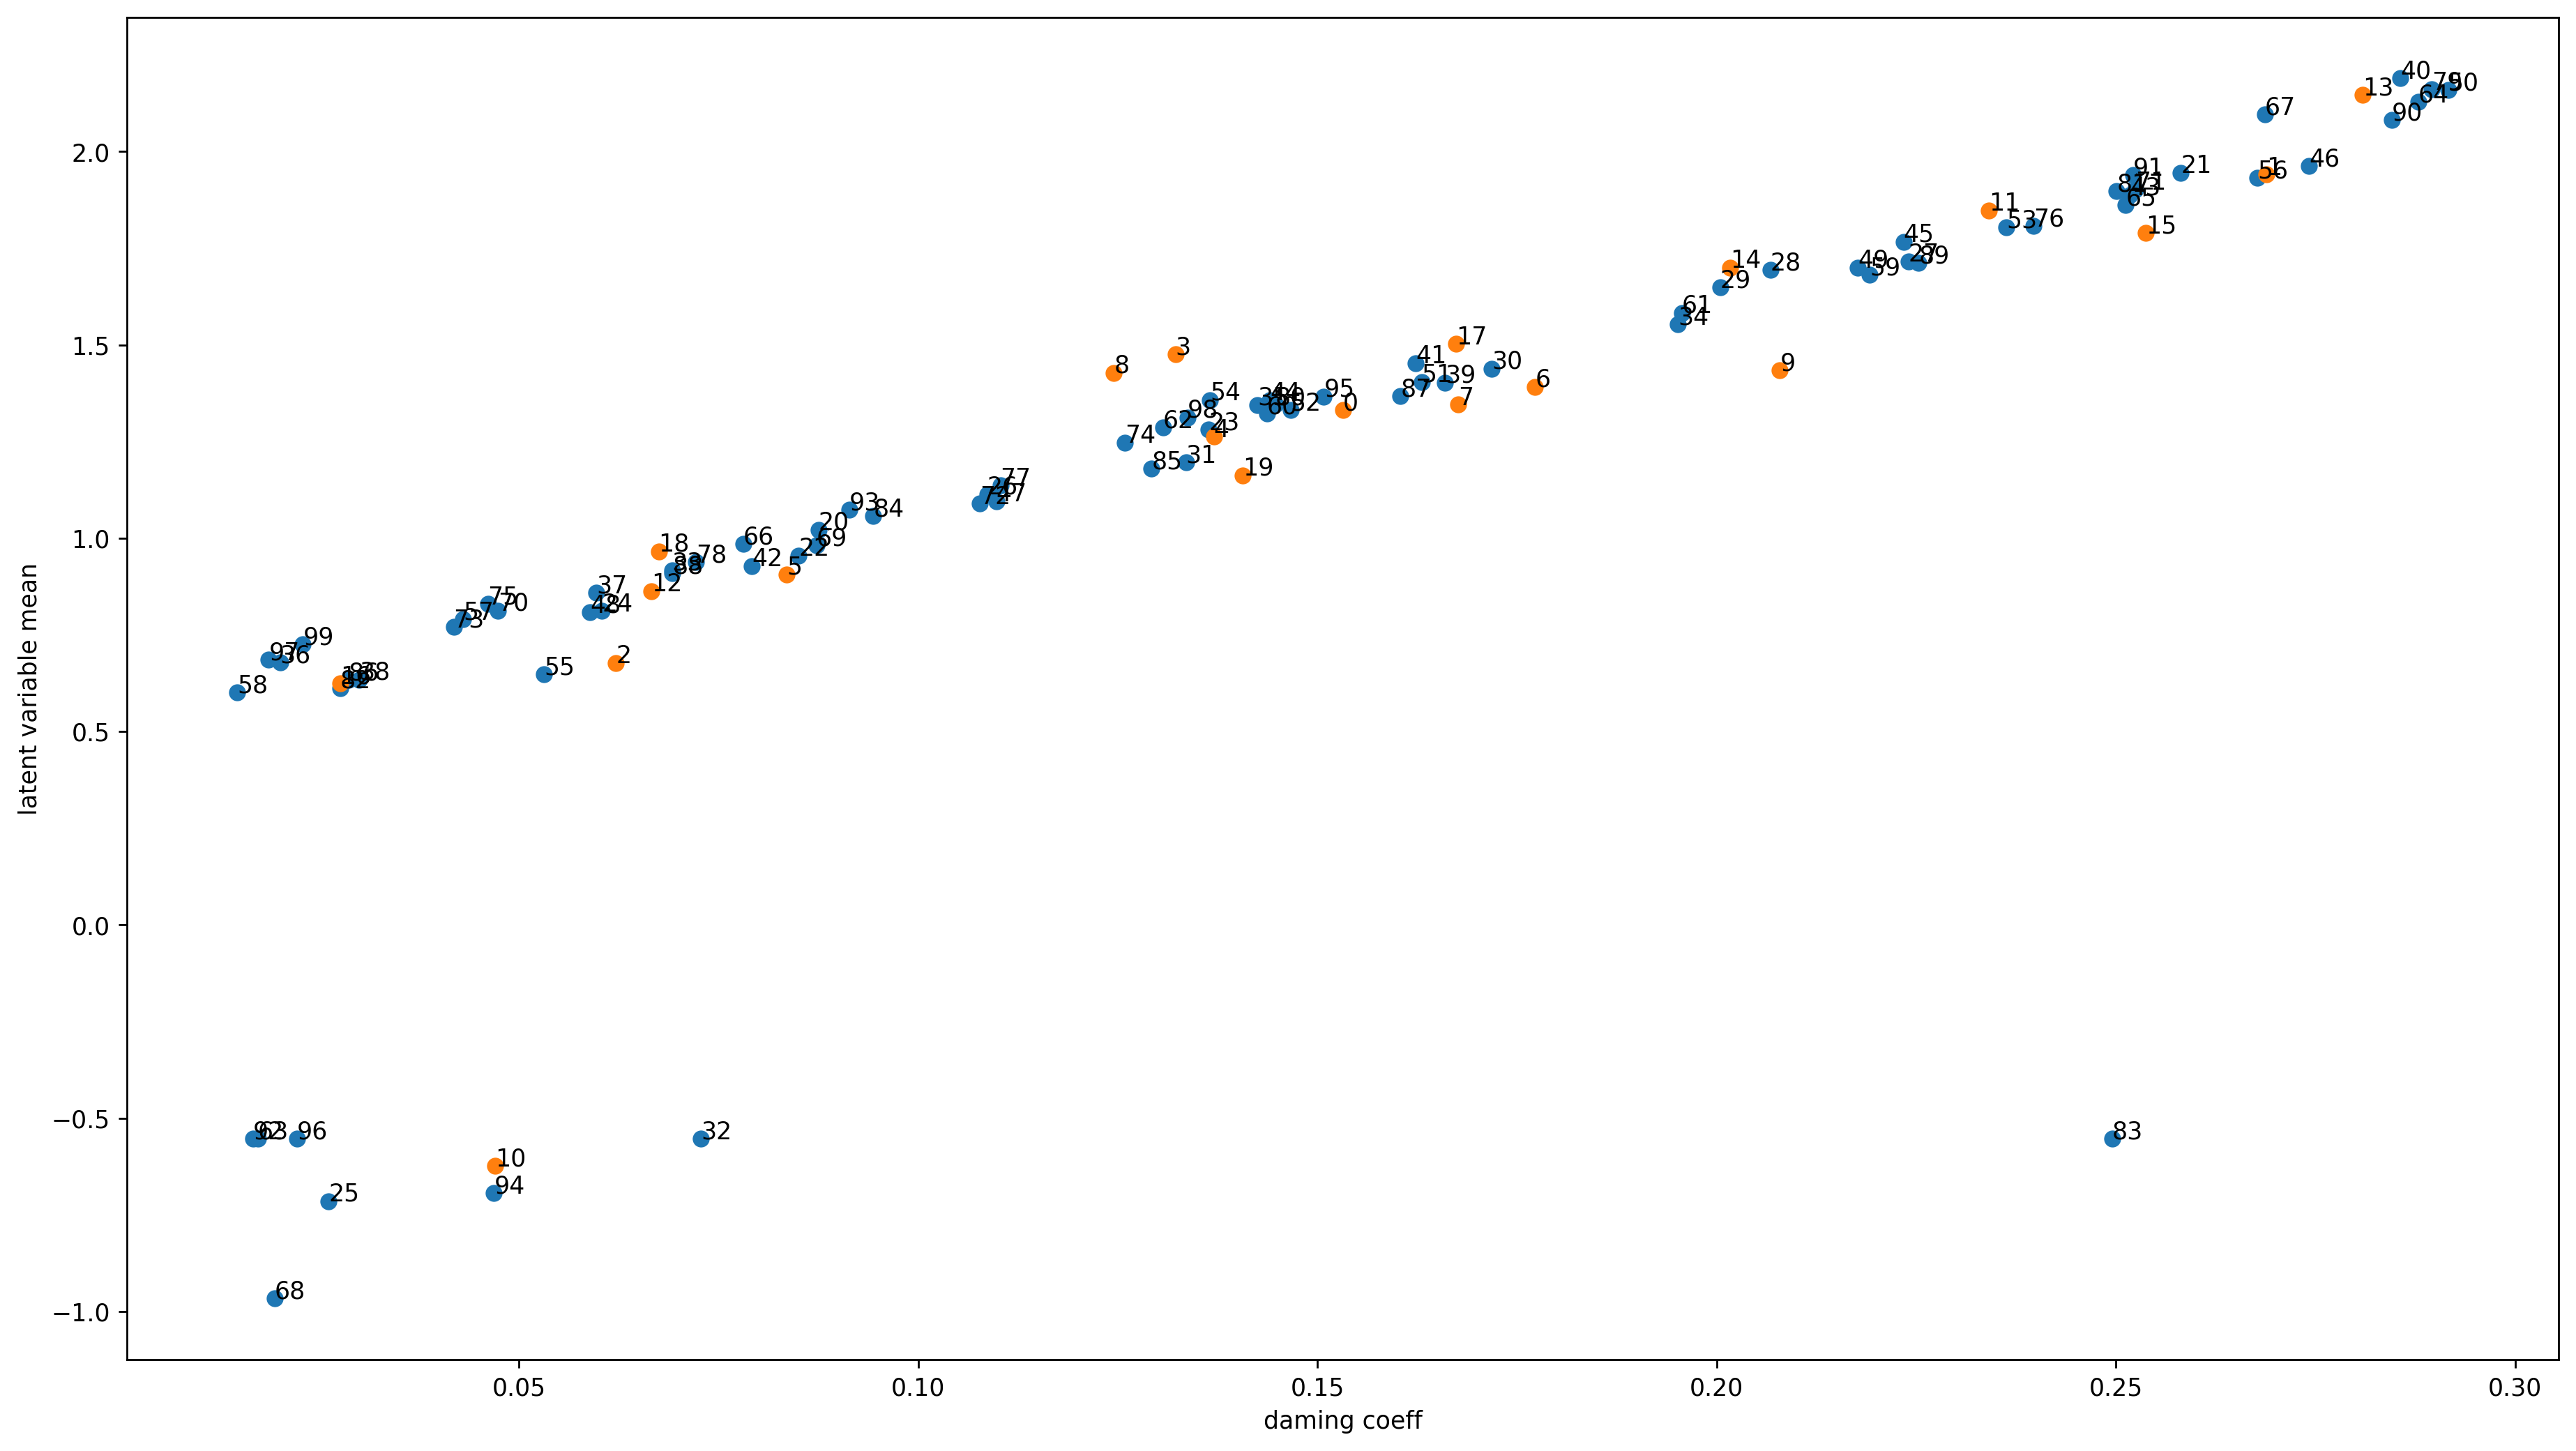

[0.15324828 0.26888793 0.06217286 0.13224295 0.13704997 0.08354618
 0.17725885 0.16765623 0.12453036 0.20794138]
[0.04706032 0.23409443 0.06658737 0.28091509 0.2017151  0.25372526
 0.0276651  0.16735223 0.06751635 0.14068207]
[0.08753783 0.25816017 0.08504636 0.13638662 0.06041361 0.02616881
 0.10865286 0.22402387 0.20675412 0.20044044]
[0.17183816 0.13354351 0.07280263 0.06917526 0.19514306 0.14252658
 0.02009083 0.05969281 0.0300313  0.16598332]
[0.28563037 0.1623059  0.079166   0.25175792 0.14407199 0.2234257
 0.27419258 0.10978218 0.05891417 0.21770089]
[0.29162951 0.1630783  0.14666197 0.23628546 0.13658381 0.05316401
 0.26771796 0.0429997  0.01473268 0.21921244]
[0.14369349 0.19566694 0.13065617 0.01731945 0.28791216 0.25123873
 0.07810352 0.2686711  0.01940196 0.08726173]
[0.0474101  0.25242589 0.10773226 0.04184014 0.12587483 0.04612206
 0.2396893  0.11031089 0.0721711  0.28956844]
[0.14474911 0.25010637 0.02763948 0.24952833 0.0943959  0.12924451
 0.02867004 0.16042046 0.06925

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 6.650012493133545

 2 7.077782869338989

 3 6.881262302398682

 4 6.474360227584839

 5 6.55615496635437

 6 6.748618125915527

 7 6.56580114364624

 8 6.702627658843994

 9 6.543652534484863

 10 3.5494749546051025

 11 3.457897424697876

 12 3.522663116455078

 13 3.3610281944274902

 14 3.5825135707855225

 15 3.3195300102233887

 16 3.479856491088867

 17 3.2617249488830566

 18 3.150460720062256

 19 3.3808887004852295

 20 3.3350799083709717

 21 3.386427402496338

 22 3.5847554206848145

 23 3.4823410511016846

 24 3.614823579788208

 25 3.4484498500823975

 26 6.071697950363159

 27 7.325492858886719

 28 6.706575870513916

 29 6.618991136550903

 30 3.8338115215301514

 31 6.685413599014282

 32 3.2081079483032227

 33 5.3171281814575195

 34 3.4760539531707764

 35 6.570812702178955

 36 6.7780232429504395

 37 6.467789888381958

 38 6.973305940628052

 39 6.687914133071899

 40 6.684656858444214

 41 6.892296314239502

 42 6.736696243286133

 43 6.596313714981079

 44 6.

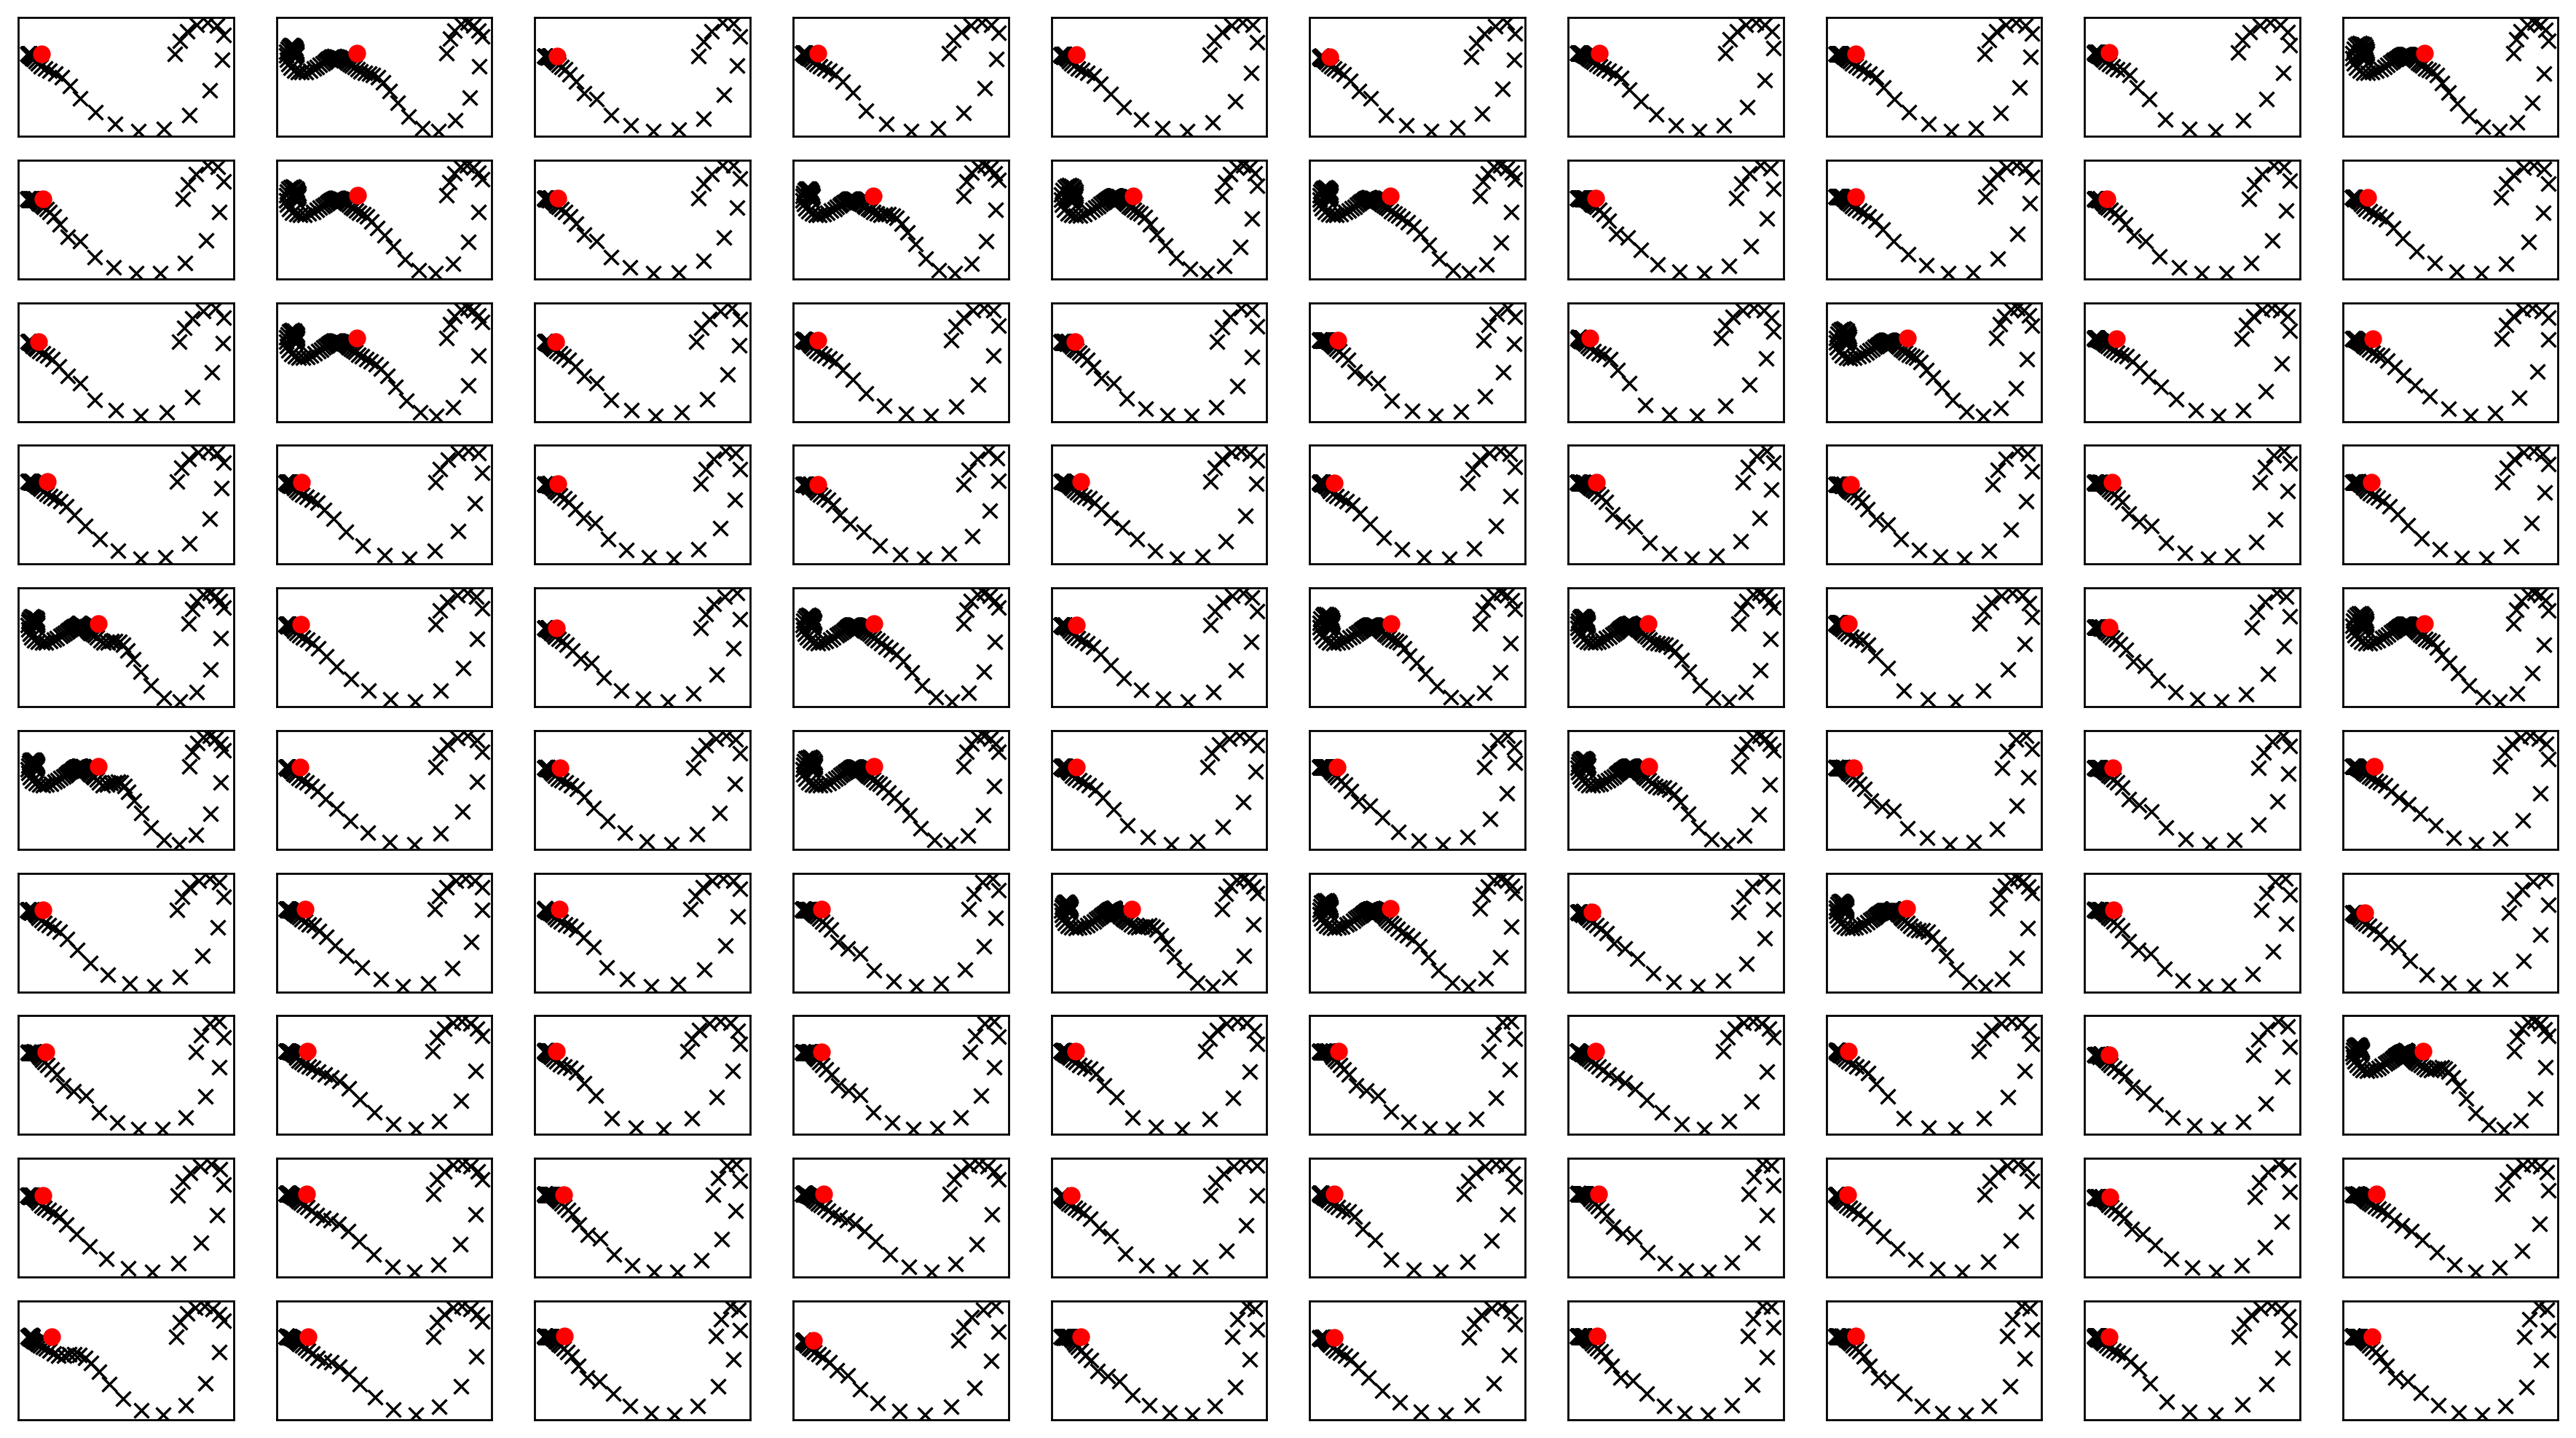

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.2135086059570312

 2 3.1908957958221436

 3 3.206545829772949

 4 3.2961292266845703

 5 3.293018102645874

 6 3.1623880863189697

 7 3.2783827781677246

 8 3.299414873123169

 9 3.241255044937134

 10 3.234586238861084

 11 3.20939564704895

 12 3.2745189666748047

 13 3.2508840560913086

 14 3.2097067832946777

 15 3.230573892593384

 16 3.276838779449463

 17 3.22151517868042

 18 3.1740641593933105

 19 3.140017032623291

 20 3.2270736694335938

 21 3.2933008670806885

 22 3.3637728691101074

 23 3.2870593070983887

 24 3.23248291015625

 25 3.2247724533081055

 26 3.287353754043579

 27 3.182882308959961

 28 3.3628809452056885

 29 3.2619693279266357

 30 3.2353503704071045

 31 3.3074042797088623

 32 3.2192304134368896

 33 3.2570455074310303

 34 3.270838975906372

 35 3.275683879852295

 36 3.237058401107788

 37 3.3555033206939697

 38 3.259315013885498

 39 3.2954001426696777

 40 3.2841625213623047

 41 3.3092172145843506

 42 3.2893290519714

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())